Fang et al. algorithm implementation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline, interp1d
from scipy.interpolate import LSQUnivariateSpline
from scipy.integrate import quad
from scipy.optimize import minimize
import warnings
from time import sleep
%matplotlib widget

printing = 0

file = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/msis.txt'

kb = 1.380649e-23 #in SI units 
re = 6371000      #in m
g = 9.81          #in m/s^2

"""
Energy dissipation function
Preparation:
Copy values provided by Semeter and Kamalabadi
Fit it with LSQUnivariateSpline to get rid of wiggles
Evaluate calling the resulting function
Normalize such that int(energy_diss_f, -1, 1) = 1
"""
#raw data:
E_diss_table = np.array([
               [-0.525, 0.000], [-0.500, 0.006], [-0.475, 0.020], [-0.450, 0.027], [-0.425, 0.042], [-0.400, 0.058], [-0.375, 0.069], 
               [-0.350, 0.091], [-0.325, 0.123], [-0.300, 0.145], [-0.275, 0.181], [-0.250, 0.214], [-0.225, 0.248], [-0.200, 0.313],
               [-0.175, 0.360], [-0.150, 0.431], [-0.125, 0.499], [-0.100, 0.604], [-0.075, 0.728], [-0.050, 0.934], [-0.025, 1.237], 
               [ 0.000, 1.686], [ 0.025, 1.995], [ 0.050, 2.063], [ 0.075, 2.024], [ 0.100, 1.946], [ 0.125, 1.846], [ 0.150, 1.761], 
               [ 0.175, 1.681], [ 0.200, 1.596], [ 0.225, 1.502], [ 0.250, 1.421], [ 0.275, 1.346], [ 0.300, 1.260], [ 0.325, 1.190], 
               [ 0.350, 1.101], [ 0.375, 1.043], [ 0.400, 0.972], [ 0.425, 0.888], [ 0.450, 0.834], [ 0.475, 0.759], [ 0.500, 0.689], 
               [ 0.525, 0.636], [ 0.550, 0.567], [ 0.575, 0.504], [ 0.600, 0.450], [ 0.625, 0.388], [ 0.650, 0.334], [ 0.675, 0.282], 
               [ 0.700, 0.231], [ 0.725, 0.187], [ 0.750, 0.149], [ 0.775, 0.113], [ 0.800, 0.081], [ 0.825, 0.058], [ 0.850, 0.037], 
               [ 0.875, 0.023], [ 0.900, 0.010], [ 0.925, 0.002], [ 0.950, 0.000]
                ])

#lsq fit using splines of order 5, using 5 datapoints to fit
i1 = 21
knots = np.arange(0.01, 0.9, 0.1)
spl = LSQUnivariateSpline(E_diss_table[i1:, 0], E_diss_table[i1:, 1], knots, k = 5)
cs = CubicSpline(E_diss_table[:, 0], E_diss_table[:, 1], bc_type = 'clamped')

if printing: 
    plt.figure()
    s = np.arange(-0.01, 1, 0.001)
    plt.plot(s, spl(s))
    plt.plot(E_diss_table[i1:, 0], E_diss_table[i1:, 1], 'x')
    plt.grid()

def E_diss_func(s, R):
    """
    Returns the energy dissipation function evaluated at s/R, (as defined in Semeter and Kamalabadi)
    by looking up the value in the E_diss_table and interpolating.
    R is the range of an electron in air with energy E.
    
    Parameters:
    s: scattering depth along the magnetic field: s = sec(I) * int(density dy)(0..inf), I: inclination angle of B
        scalar
    E: Energy of electron (eV)
        scalar
    
    Returns:
    The energy dissipation function evaluated at s/R.
    """
    if s/R < 0: 
        warnings.warn("s/R < 0 encountered")
        if s/R < -0.525: return 0
        else:
            index = int(np.floor(s/R/0.025 + 21))
            #print(s/R, E_diss_table[index, 0])
            #interpolation
            inter = cs(s/R)
            return inter/0.9996445827348939
    elif s/R > 0.950: return 0
    else:
        e_diss = spl(s/R)
        return e_diss/0.9996445827348939
    

def e_range(E):
    """
    Calculates the (density normalized) range of an electron in air in kg/m^2
    Actual distance d = R / density
    
    Parameters:
    E: Electron energy (eV)
        scalar or ndarray
    
    Returns:
    R: The density normalized range [kg m^-2]
        same shape as E
    """
    kE = E/1000
    R = (4.3 + 53.6 * (kE**(1.67)) - 0.038 * (kE**(-0.7)))*1e-6 #kg m-2
    return R


def scattering_depth_sh(rho, H, z, z_lower, inc_B):
    """
    Returns the scatterig depth at distance z, projected along the magnetic field
    Using the scale height sh(m(z), g(z), T(z)) to compute density variations, also to +inf
    
    Parameters:
    rho: mass density profile (discretized by z)
        ndarray [1 x n]
    H: scale height profile (discretized by z)
        ndarray [1 x n]
    z: heights of the profile (discretization parameter of rho and H)
        ndarray [1 x n]
    z_lower: lower integration boundary 
        scalar
    I: Inclination angle
        scalar
       
    Returns:
    scattering depth s in [kg m^-2]
    """
    #filtering in height:
    
    ind = z>=z_lower
    alt = z[ind]
    m_density = rho[ind]
    h_scale = H[ind]
        
    delta_alt = alt[1:] - alt[:-1]
    #s = 1/np.cos(inc_B) * np.sum(m_density[:-1] * delta_alt)
    #implicitly, above code asks for a high resolution in height.
    #if not enough measurements of rho in height, possible to interpolate using scale height
    #formula using scale heigh H: sum(rho(z) * delta_z) => sum_i[int(rho(z) dz)(z_i .. z_i+1)]
    #with int(rho(z) dz)(z_i .. z_i+1) = rho_i * H_i * [exp(-(z_i+1 - z_i)/H_i) - 1]
    #where H_i is the scale height at altidute z_i, and assuemd to be constant in z_i.
    delta_alt = np.append(delta_alt, np.inf)
    s = np.sum(m_density * h_scale * (1 - np.exp(-delta_alt/h_scale)))
    if(z_lower > z[-1]):
        s = rho[-1] * H[-1] * np.exp(-(z_lower - z[-1])/H[-1])
    elif z_lower < alt[0]:
        s = m_density[0] * h_scale[0] * (1 - np.exp(-(alt[0] - z_lower)/h_scale[0]))
    s = s/np.cos(inc_B)
    return s


def scattering_depth(rho, z, z_lower, inc_B):
    """
    Returns the scatterig depth at distance z, projected along the magnetic field
    Only does a simple sum. If more sophisticated procedures are needed, rewrite,
    or just provide higher resolved z, rho(z)
    
    Parameters:
    rho: mass density profile (discretized by z)
        ndarray [1 x n]
    z: heights of the profile (discretization parameter of rho and H)
        ndarray [1 x n]
    z_lower: lower integration boundary 
        scalar
    I: Inclination angle
        scalar
    res: desired height resolution. rho is interpolated to be resolved in height according to res.   
    
    Returns:
    scattering depth s in [kg m^-2]
    """
    #def interp_rho(d):
    #    return np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(d))
    
    ind = z>=z_lower
    alt = z[ind]
    m_density = rho[ind]
    
    if z_lower != alt[0]: print(z_lower, alt[0])
    
    delta_alt = alt[1:] - alt[:-1]
    s = 1/np.cos(inc_B) * np.sum(m_density[:-1] * delta_alt)
    return s


#check shape of E_diss_func
if printing:
    s = np.arange(-1, 1, 0.001)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    plt.figure()
    plt.plot(s, e_diss, label = 'interpolation cubic splines')
    plt.plot(E_diss_table[:, 0], E_diss_table[:, 1], 'x', label = 'Values Semeter')
    plt.legend()
    plt.title('Energy dissipation function')
    plt.xlabel('s/R')
    plt.ylabel('Lambda')
    plt.show()


if printing:
    e = np.logspace(2, 4 , 100)
    plt.figure()
    plt.plot(e, e_range(e))
    plt.xscale('log')
    plt.yscale('log')
    

#check if energy dissipation adds up to 1:
if printing:
    res = 0.000001
    res = 0.001
    s = np.arange(-1, 1, res)
    e_diss = list(map(E_diss_func, s, np.ones(len(s))))
    print('Integration of Energy dissipation function -1..1 = ', np.sum(e_diss) * res)
    

def interp_z_md(z, rho, z_min, z_max, res):
    zp = np.arange(z_min, z_max, res)
    return zp, np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(zp))

def interp_md(z, rho, zp):
    """
    Interpolates the mass density in an exponential fashion along the height z.
    
    Parameters:
    z: list of heights along which the mass density is known
        ndarray
    rho: mass density as an array along heights z
        ndarray
    zp: point to evaluate the interpolated function at.
        ndarray
        
    Returns:
    The mass density at the heights zp
    """
    return np.exp(interp1d(z, np.log(rho), fill_value = 'extrapolate')(zp))


In [2]:
#get length, define data array size
f = open(file, 'r')
n_lines = len(f.readlines())
data = np.zeros([n_lines - 18, 7])

#get data into data array
f = open(file, 'r')
for i, line in enumerate(f.readlines()[18:]):
    data[i] = line.split()
    
#print first few lines
if printing:
    f = open(file, 'r')
    for i in range(22):
        print(f.readline().replace('\n', ''))
        continue
    
#more intuitive names and SI unit conversion
z            = data[:, 0]*1e3 #[height in m]
o1_density   = data[:, 1]*1e6 #[number density in m^3]
n2_density   = data[:, 2]*1e6 #[number density in m^3]
o2_density   = data[:, 3]*1e6 #[number density in m^3]
mass_density = data[:, 4]*1e3 #[mass density (density in kg/m^3]
temp         = data[:, 5]     #[temeperature in K]
number_density = np.sum(np.array([o1_density, o2_density, n2_density]), 0)
mean_molecular_mass = mass_density/number_density

avarage_molecular_mass = mass_density/number_density
#calculate scale height hz:
hz = kb * temp * (re**2 + z**2) / (avarage_molecular_mass * g * re**2)

In [3]:
"""interpolating data points to higher resolution"""
#resolution:
res = 100
#interpolating + extrapolating range:
zp = np.arange(0, 800001, res)
hzp = interp1d(z, hz, fill_value='extrapolate')(zp)
mdp = np.exp(interp1d(z, np.log(mass_density), fill_value='extrapolate')(zp))

if printing:
    plt.figure()
    plt.title('Mass Density')
    plt.plot(mass_density, z/1e3, 'o-')
    plt.plot(mdp, zp/1e3, 'x-')
    plt.xlabel('Mass Density [kg/m^3]')
    plt.ylabel('Altidude [km]')
    plt.xscale('log')

In [4]:
#testing scattering depth:
if printing:
    s = [scattering_depth_sh(mass_density, hz, z, z_lower, 0) for z_lower in z]
    sp = [scattering_depth_sh(mdp, hzp, zp, z_lower, 0) for z_lower in zp]
    spp = [scattering_depth(mdp, zp, z_lower, 0) for z_lower in zp]

    
    plt.figure()
    plt.plot(s, z/1e3, label = 'using scale height, standart res')
    plt.plot(sp, zp/1e3, label = 'using scale height, standart resx10')
    plt.plot(spp, zp/1e3, label = 'no scale height, resx10')

    plt.xlabel('Scattering Depth [kg/m^2]')
    plt.ylabel('Altidude [km]')
    plt.xscale('log')
    plt.legend()
    #plt.ylim(50000, 300000)
    plt.plot()

In [5]:
e_mean = 1e3
ar = np.zeros(len(z))

for i in range(len(z)):
    scat_d = scattering_depth(mdp, zp, z[i], 0)
    ran = e_range(e_mean)
    energy_diss = E_diss_func(scat_d, ran)
    ar[i] = energy_diss
    #print(z[i], scat_d, ran, energy_diss)

if printing:
    plt.figure()
    plt.xscale('log')
    plt.plot(ar*mass_density, z/1e3, label='energy dissipation func')
    plt.plot(mass_density, z/1e3, label='density')
    plt.plot([scattering_depth(mdp, zp, z[i], 0) for i in range(len(z))], z/1e3, label='scat:d')
    plt.plot([ran, ran], [z[0]/1e3, z[-1]/1e3], label='range')
    plt.legend()
    plt.ylabel('Altidude [km]')

In [6]:
#differential flux: energy binning: 
e_bin_lims = np.logspace(2, 2+3, 501)
e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]

#array of monoenergetic differential fluxes, all with a number flux of 10^12 and energy according to df_meanEnergy
number_flux = 1e10 #[m-2 s-1]
diff_flux = number_flux / e_bin_width

In [7]:
#defining parameters
inc_B = 0
z_min = 70000
z_max = 600000
res_fm = 100
z_sd_min = 0
z_sd_max = 800e3
res_sd = 10

"""
Building forward model
"""
#filtering altitude
def forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B):
    """ 
    builds a forward model for electron production due to a differential flux into the ionosphere accoring
    to Semeter and Kamalabadi (2005).
    
    Parameters:
    z_min: lower altitude of forward model IN METERS
        scalar
    z_max: upper altudute of forward model IN METERS
        scalar
    res_fm: resolution of the forward model in height, used to interpolate density IN METERS
        scalar
    z_sd_min: lower altitude to calculate scattering depth IN METERS
        scalar
    z_sd_max: upper altitude to calculate scattering depth IN METERS
        scalar
    res_sd: resolution in height of density in height for calculation of scattering depth IN METERS
        scalar
    e_bin_lims: limits of energy bins
        ndarray
    z: parametrization of mass_density (height information)
        ndarray
    mass_density: mass_density resolved in height, parametrized by z
        ndarray
    inc_B: inclination of the magnetic field.
        scalar
        
    Returns:
    fm, the forward model and the corresponding heights z_fm 
    """
    
    z_fm = np.arange(z_min, z_max, res_fm)
    md_fm = interp_md(z, mass_density, z_fm)
    
    z_sd = np.arange(z_sd_min, z_sd_max, res_sd)
    md_sd = interp_md(z, mass_density, z_sd)
    
    e_bin_mean = (e_bin_lims[1:] + e_bin_lims[:-1]) / 2
    e_bin_width = e_bin_lims[1:] - e_bin_lims[:-1]
    
    fm = np.zeros([len(z_fm), len(e_bin_mean)])
    for i in range(len(z_fm)):
        if i/len(z_fm)%0.1 == 0: print(i/len(z_fm)) 
        #use interpolated values for mass density (mdp) and height (zp)
        scat_d = scattering_depth(md_sd, z_sd, z_fm[i], inc_B)
        for j in range(len(e_bin_mean)):
            ran = e_range(e_bin_mean[j])
            energy_diss = E_diss_func(scat_d, ran)
            fm[i, j] = energy_diss * md_fm[i] * e_bin_mean[j] * e_bin_width[j] / (35.5 * ran)
    return fm, z_fm

fm, z_fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
        
if printing:
    plt.figure()
    for i in range(5):
        plt.plot(fm[:, i*100]*diff_flux[i*100], np.arange(z_min, z_max, res_fm)/1e3, label = '%.2f keV' % (e_bin_mean[i*100]/1000))#, marker = '.')
    plt.xscale('log')
    plt.ylabel('Altidude [km]')
    plt.xlabel('Ion production rate [m^-3 s^-1]')
    plt.legend()
    plt.grid()
    #plt.ylim(50, 300)
    #plt.xlim(1e5, 1e11)

#fm.shape

0.0
0.1
0.2
0.4
0.8


In [8]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 1000
    fm, z_fm  = forward_model(70e3,   400e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [9]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 100
    fm, z_fm = forward_model(70e3,   600e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

In [10]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 1000
    res_sd = 10
    fm, z_fm  = forward_model(70e3,   400e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

0.0
0.1
0.2
0.4
0.8


Text(0, 0.5, 'Energy flux / production rate [ev]')

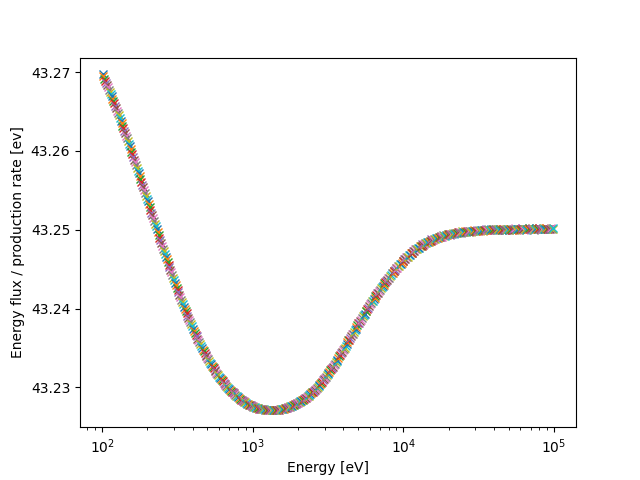

In [11]:
#fm =      forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
res_fm = 100
res_sd = 10
fm, z_fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max , res_sd, e_bin_lims, z, mass_density, inc_B)

plt.figure()
for i in range(len(e_bin_mean)):
    ener_flux = number_flux*e_bin_mean[i]
    prod = fm[:, i] * diff_flux[i]
    e_coll = ener_flux / (np.sum(prod)*res_fm)
    plt.plot(e_bin_mean[i], e_coll, 'x')
plt.xscale('log')
plt.xlabel('Energy [eV]')
plt.ylabel('Energy flux / production rate [ev]')

In [12]:
if printing:
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm = 10
    res_sd = 10
    fm, z_fm  = forward_model(70e3,   600e3, res_fm,   0,        800e3 , res_sd, e_bin_lims, z, mass_density, inc_B)
    
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        e_coll = ener_flux / (np.sum(prod)*res_fm)
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')

Insight from testing:
- Use high resolution for scattering depth. Since it is an interpolation and summation, it is fast. Use a higher z_max_sd than z_max, to counter the effect that the upper part of the atmosphere is neglected when calculating the scattering depth.
- Use height resolution of about 100m for forward model to avoid oscillations in energy flux / production rate (should equal to 35.5eV). This is due to resolution of the peak in the ionization profile. Higher resolution does not change much.
- Energy flux / production rate is not equal to energy dissipation per ionization (35.5eV), but 43eV. Reason unknown. One hint is the height of the forward model: Energy lost above z_max is not counted in.
- Use z_max higher tham 400km (preferably 600km), since low energy electrons loose a considerable part of their energy at these heights. From 600km, the difference is negligible. The effect mostly acts of small energies, from 1keV, it becomes negligible.

In [13]:
if printing:
    from scipy.interpolate import CubicSpline
    plt.figure()
    for i in range(len(e_bin_mean)):
        ener_flux = number_flux*e_bin_mean[i]
        prod = fm[:, i] * diff_flux[i]
        cs = CubicSpline(z_fm, prod)
        n = np.arange(z_fm[0], z_fm[-1], 1)
        qp = cs(n)
        e_coll = ener_flux / (np.sum(qp))
        plt.plot(e_bin_mean[i], e_coll, 'x')
    plt.xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')
    

In [14]:
if printing:
    plt.figure()
    plt.pcolormesh(e_bin_mean/1e3, z_fm/1e3, np.log(fm))
    plt.xscale('log')
    plt.colorbar()
    plt.ylabel('Altidude [km]')
    plt.xlabel('Energy [keV]')
    #plt.ylim(70, 300)
    #plt.xlim(2e-1, 3e1)
    

0.0
0.1
0.2
0.4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8


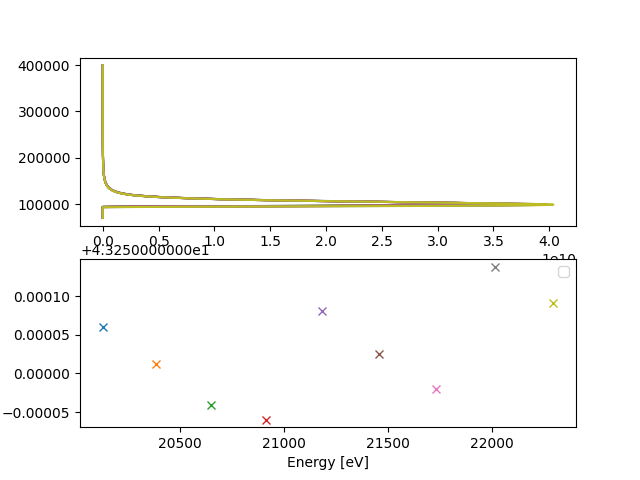

In [15]:
"""investigate oscillatons in energy flux / production rate ( = aprrox. 35.5 eV)"""
printing = 1
if printing:
    #differential flux: energy binning:
    e_bin_lims_test = np.logspace(4, 4.05, 10)*2
    e_bin_mean_test = (e_bin_lims_test[1:] + e_bin_lims_test[:-1]) / 2
    e_bin_width_test = e_bin_lims_test[1:] - e_bin_lims_test[:-1]
    
    #array of monoenergetic differential fluxes, all with a number flux of 10^12 and energy according to df_meanEnergy
    number_flux_test = 1e12 #[m-2 s-1]
    diff_flux_test = number_flux_test / e_bin_width_test
    
    #fm = forward_model(z_min, z_max, res_fm, z_sd_min, z_sd_max, res_sd, e_bin_lims, z, mass_density, inc_B)
    res_fm_test = 100
    res_sd_test = 10
    fm_test, z_fm_test  = forward_model(70e3,   400e3, res_fm_test,   0,        800e3 , res_sd_test, e_bin_lims_test, z, mass_density, inc_B)
    
    fig, ax = plt.subplots(2)
    for i in range(len(e_bin_mean_test)):
        ener_flux_test = number_flux_test*e_bin_mean_test[i]
        prod_test = fm_test[:, i] * diff_flux_test[i]
        ax[0].plot(prod_test, z_fm_test, label = 'E = %.f0 eV' % e_bin_mean_test[i])
        e_coll_test = ener_flux_test / (np.sum(prod_test)*res_fm_test)
        ax[1].plot(e_bin_mean_test[i], e_coll_test, 'x')
    #ax[0].set_xscale('log')
    plt.xlabel('Energy [eV]')
    plt.ylabel('Energy flux / production rate [ev]')
    plt.legend()

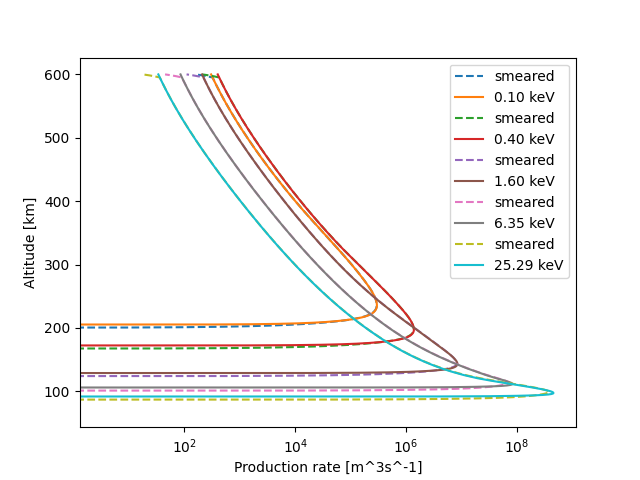

In [16]:
#to simulate pulse smearing (ps), use a gliding average on the production profiles q (= fm[:, i])
pulse_height = 10000
ps_range = pulse_height / res_fm
pulse_smearer = np.ones(np.int_(ps_range))
pulse_smearer = pulse_smearer / np.sum(pulse_smearer) #ensures that the pulse smearer always has norm 1

fm_ps = np.array([np.convolve(height_prof, pulse_smearer, 'same') for height_prof in fm.T]).T

if printing:
    plt.figure()
    for j in range(np.int_(fm.shape[1]/100)):
        i = j * 100
        plt.plot(fm_ps[:, i]*diff_flux[i], z_fm/1e3, label = 'smeared', ls = '--')
        plt.plot(fm[:, i]*diff_flux[i], z_fm/1e3, label = '%.2f keV' % (e_bin_mean[i]/1e3))    
        plt.legend()
        plt.xscale('log')
        plt.xlabel('Production rate [m^3s^-1]')
        plt.ylabel('Altitude [km]')
        

Text(0, 0.5, 'Altitude [km]')

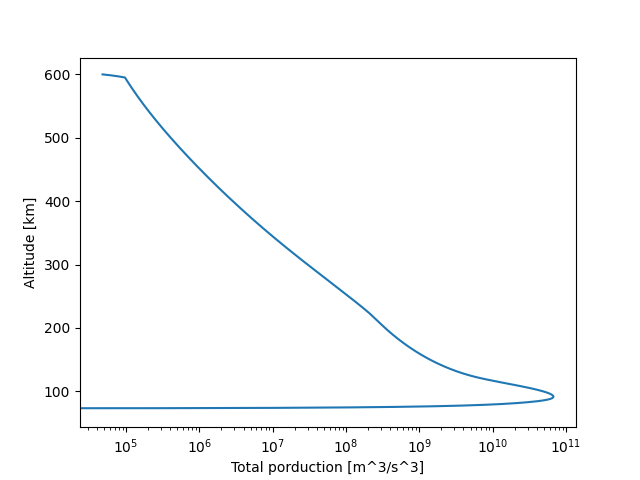

In [17]:
#production q by a differential flux diff_flux: (diff_flux still uniformly defined as above)
prod = np.dot(fm_ps, diff_flux)
plt.figure()
plt.plot(prod, z_fm/1e3)
plt.xscale('log')
plt.xlabel('Total porduction [m^3/s^3]')
plt.ylabel('Altitude [km]')

## Loading of EISCAT data

In [18]:
import scipy.io
from os import listdir
from os.path import isfile, join

#specify your directory of EISCAT data:
mypath = '/Users/ost051/Documents/PhD/Electron Precipitation/example'
data_path = mypath + '/Data/'
meta_path = mypath + '/Meta-data/'

data_files = [f for f in listdir(data_path) if isfile(join(data_path, f)) and f[-3:] == 'mat']
meta_files = [f for f in listdir(meta_path) if isfile(join(meta_path, f))]

n = len(data_files)

mat_data = [scipy.io.loadmat(data_path + file) for file in sorted(data_files)]
#[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_data[0]]
#[print(data['r_ver']) for data in mat_data]


def mat_extract_variable(loaded_mat, var):
    """
    Extracts data for variable var from pre-loaded matfiles:
    loaded_mat = scipy.io.loadmat(path_to_file)
    data = loaded_mat('var')
    CAN HANDLE JAGGED ARRAYS (at least in 1 dimension)
    
    Parameters:
    loaded_mat: preloaded mat files as a list
        ndarry
    var: Variable to be extracted
        string
        
    Returns:
    data: all data saved in the loaded_mat['var']
    """
    n = len(loaded_mat)
    #print(var)
    var_data = np.array([data[var] for data in loaded_mat])
    #print(np.array(var_data[0].shape))
    
    max_shape = np.amax([i.shape for i in var_data], axis = 0)
    #print(max_shape)
    array_size = [n, *max_shape]
    #print(array_size)

    data = np.empty(array_size, dtype = 'object')
    
    for i in range(n):
        data[i, :len(var_data[i])] = var_data[i]
    
    #print(max_shape.shape)
    if max_shape.shape == (2,):
        if max_shape[1] == 1:
            data = data.reshape(array_size[:-1])
    return data

height = mat_extract_variable(mat_data,'r_h').astype('float')
parameters = mat_extract_variable(mat_data,'r_param').astype('float')
time = mat_extract_variable(mat_data,'r_time').astype('float')
az = mat_extract_variable(mat_data,'r_az').astype('float')
el = mat_extract_variable(mat_data,'r_el').astype('float')
r_errors = mat_extract_variable(mat_data,'r_error').astype('float')

ne_meas = parameters[:, :, 0]
vel = parameters[:, :, 4]
vel_err = r_errors[:, :, 4]

#conversion to SI units:
height = height*1e3
dtime = time[:,0,5] + time[:,0,4]*60 # + time[:,0,3]*3600
dne = r_errors[:, :, 1]

"""
for k, file in enumerate(sorted(data_files)):
    if True:
        mat = scipy.io.loadmat(data_path + file)
        mat_variables = [i for i in mat]
        #print all content:
        #[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_variables]
        
#print content of last file:
[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_variables]
 
def load_mat_file(mat):
    mat = scipy.io.loadmat(data_path + file)
    mat_variables = [i for i in mat]
    #print all content:
    #[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_variables]
    #create nested lists with contents of arrays:
    #data = [var, mat[var] for var in mat_variables]
    return 0
        
#initialize lists of data to be extracted:
az = np.zeros([n])
ne = np.zeros([n, 43])
time = np.zeros([n, 2, 6])
height = np.zeros([n, 43, 1])


#load and extract files:
j = 0
for k, file in enumerate(sorted(onlyfiles)):
    if True:
        mat = scipy.io.loadmat(mypath + file)
        if mat['r_az'] < 182:
            j = j+1
            continue
        i = k-j
        parameters = mat['r_param']
        time[i, :] = mat['r_time']
        height[i, 0:len(mat['r_h'])] = mat['r_h']
        ne[i, 0:len(mat['r_h'])] = parameters[:, 0]
        az[i] = mat['r_az']


height = height.reshape([-1,43])
dtime = time[:,0,3] + time[:,0,4]/60 + time[:,0,5]/3600

#see data:
#print(time)
    
#maybe have a look in a single file:
#mat = scipy.io.loadmat(mypath + onlyfiles[0])
#print(mat)
len(height)
"""

"\nfor k, file in enumerate(sorted(data_files)):\n    if True:\n        mat = scipy.io.loadmat(data_path + file)\n        mat_variables = [i for i in mat]\n        #print all content:\n        #[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_variables]\n        \n#print content of last file:\n[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_variables]\n \ndef load_mat_file(mat):\n    mat = scipy.io.loadmat(data_path + file)\n    mat_variables = [i for i in mat]\n    #print all content:\n    #[print(i, '='*30, '\n', mat[i],  '\n') for i in mat_variables]\n    #create nested lists with contents of arrays:\n    #data = [var, mat[var] for var in mat_variables]\n    return 0\n        \n#initialize lists of data to be extracted:\naz = np.zeros([n])\nne = np.zeros([n, 43])\ntime = np.zeros([n, 2, 6])\nheight = np.zeros([n, 43, 1])\n\n\n#load and extract files:\nj = 0\nfor k, file in enumerate(sorted(onlyfiles)):\n    if True:\n        mat = scipy.io.loadmat(mypath + file)\n        if m

In [19]:
if printing:
    mat_variables = [i for i in mat_data[0]]
    print(mat_variables)
    
    for i in mat_variables:
        mat_extract_variable(mat_data, i)

#mat_data[0]

['__header__', '__version__', '__globals__', 'r_ver', 'name_expr', 'name_site', 'name_ant', 'r_time', 'r_az', 'r_el', 'r_Pt', 'r_m0', 'r_range', 'r_h', 'r_param', 'r_error', 'r_res', 'r_status', 'r_dp', 'r_w', 'r_apriori', 'r_apriorierror', 'r_pp', 'r_pprange', 'r_pperr', 'r_ppw', 'r_XMITloc', 'r_RECloc', 'r_SCangle', 'r_Tsys', 'r_Magic_const', 'r_om0', 'name_sig']


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
printing = 1
if printing:
    plt.figure()
    plt.pcolormesh(dtime, height[0], np.log10(ne_meas.T), vmin = 11, vmax = 12)
    plt.xlabel('Time [s]')
    plt.ylabel('Altitude [km]')
    cb = plt.colorbar()
    cb.set_label('Log10 (Electron Density) [m-3]')

In [ ]:
ne_meas[0]
dne[0]

In [ ]:
printing = 1
if printing:
    plt.figure()
    plt.errorbar(ne_meas[4], height[0]/1e3, xerr = dne[4])
    plt.xlabel('Measured electron density [m-3]')
    plt.ylabel('Height [km]')

## Load IRI data:

In [ ]:
#read IRI file
iri_file = '/Users/ost051/Documents/PhD/Electron Precipitation/example/Meta-data/iri.txt'
skip_lines = 27

#get length, define data array size
f = open(iri_file, 'r')
n_lines = len(f.readlines())
data = np.zeros([n_lines - skip_lines, 15])

#get data into data array
f = open(iri_file, 'r')
for i, line in enumerate(f.readlines()[skip_lines:]):
    data[i] = line.split()
    
#print first few lines
if printing:
    f = open(iri_file, 'r')
    for i in range(42):
        print(f.readline().replace('\n', ''))
        continue
    
#more intuitive names and SI unit conversion
z_iri        = data[:, 0]*1e3 #[height in m]
ne_iri       = data[:, 1]*1e6 #[number density in m^3]
t_neutral    = data[:, 3]     #[Neutral Temperature in K]
t_ion        = data[:, 4]     #[Ion Temperature in K]
t_e          = data[:, 5]     #[Electron Temperature in K]
rel_o_p      = data[:, 6]     #[O+ percentage of ions]
rel_n_p      = data[:, 7]     #[N+ percentage of ions]
rel_h_p      = data[:, 8]     #[H+ percentage of ions]
rel_he_p     = data[:, 9]     #[He+ percentage of ions]
rel_o2_p     = data[:,10]     #[O2+ percentage of ions]
rel_no_p     = data[:,11]     #[NO+ percentage of ions]

#replace all values where t_e is -1 to 300:
t_e = np.array([t if t!= -1 else 300 for t in t_e])

=> calculate effective recombination rate

In [ ]:
if printing:
    plt.figure()
    plt.plot(rel_o_p, z_iri/1e3, label = 'O+')
    plt.plot(rel_n_p, z_iri/1e3, label = 'N+')
    plt.plot(rel_h_p, z_iri/1e3, label = 'H+')
    plt.plot(rel_he_p, z_iri/1e3, label = 'He+')
    plt.plot(rel_o2_p, z_iri/1e3, label = 'O2+')
    plt.plot(rel_no_p, z_iri/1e3, label = 'NO+')
    plt.legend()
    plt.xlabel('Percent [%]')
    plt.ylabel('Altitude [km]')
    
    plt.figure()
    plt.plot(ne_iri, z_iri/1e3)
    plt.xlabel('Electron Density [m-3]')
    plt.ylabel('Altitude [km]')
    
    plt.figure()
    plt.plot(t_e, z_iri/1e3)
    plt.xlabel('ELectron Temperature [K]')
    plt.ylabel('Altitude [km]')

In [ ]:
#effective recombination rate:
no_p_recr = 2.1e-13 * (t_e/300)**(-0.85)
o2_p_recr = 1.9e-13 * (t_e/300)**(-0.5)

eff_recr = rel_no_p * no_p_recr + rel_o2_p * o2_p_recr

if printing:
    plt.figure()
    plt.plot(eff_recr, z_iri/1e3)
    plt.ylabel('Altitude [km]')
    plt.xlabel('Effective Recombination rate [m3/s]')
    
if printing:
    plt.figure()
    plt.plot(eff_recr*ne_iri, z_iri/1e3)
    plt.ylabel('Altitude [km]')
    plt.xlabel('Electron loss (alpha ne**2) [s-1]')

In [ ]:
z_iri.shape

In [ ]:
eff_recr.shape

In [ ]:
#interpolate electron density for first estimate, and effective recombination for general use:
z_interp = np.arange(z_min, z_max, res_fm)
ne = CubicSpline(z_iri, ne_iri)(z_interp)
err = CubicSpline(z_iri, eff_recr)(z_interp)

#correct for netgative values:
ne = np.array([n if n>0 else 0 for n in ne])

plt.figure()
plt.plot(ne, z_interp/1e3)
plt.plot(ne_iri, z_iri/1e3, 'x')

r_time = time[:,0,3]*3600 + time[:,0,4]*60 + time[:,0,5]

#diff_flux => to be iteratively retrieved
#fm_ps => needs to be recalculated for given atmospheric parameters
#eff_recr => needs to be calculated for given atmospheric parameters

In [ ]:
dndt = np.dot(fm_ps, diff_flux) - err * ne 

In [ ]:
ne + dndt

In [ ]:
if printing:
    plt.figure()
    plt.plot(ne, z_interp, label = 'interpolated Ne IRI')
    plt.plot(dndt, z_interp, label = 'dn/dt')
    plt.plot(ne + dndt, z_interp, label = 'ne + dn/dt')
    plt.plot(ne_meas[1], height[1], label = 'ne_meas')
    plt.xscale('log')
    plt.legend()
    plt.xlabel('Electron Density [m-3]')
    plt.ylabel('Altitude [km]')

In [ ]:
plt.figure()
plt.plot(ne_tp1, z_interp)
plt.xscale('log')

In [ ]:
def sos(param, ne_meas, var,  dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = maxwell_diff_flux(e_bin_mean, *param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_interp, ne_tp1, zr_lim[i], zr_lim[i+1])
    sumofs = np.sum((ne_meas - ne_int)**2 / var**2)
    return sumofs

def sos2(param, ne_meas, var,  dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Calculates the Sum of Squares
    
    Parameters:
    diff_flux: variable to be optimized. Differential flux precipitating on the ionosphere.
        dn/dt = fm_p . diff_flux - eff_recr * ne_0
        ndarray 
    ne_meas: measured electron density
        ndarray
    var: variances of ne_meas
        ndarray
    dt: timestep to progress the integration
        scalar
    t0: integration start time
        scalar
    t1: integration end time
        scalar
    fm_ps: the pulse-smeared forward model for priduction.
        ndarray
    ne_0: initial electron density estimate. is replaced after dt with the ne_t1p = ne + dn/dt * dt
        ndarray
    eff_recr: effective recombination rate
        ndarray
    
    Returns:
    sumofs: Sum of Square: Differences between m_meas and height-integrated ne_int, weighted by the variance var.
    """
    diff_flux = pol_diff_flux(e_bin_mean, param)
    ne_tp1 = ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr)
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_interp, ne_tp1, zr_lim[i], zr_lim[i+1])
    sumofs = np.sum((ne_meas - ne_int)**2 / var**2)
    return sumofs
    
    
def ne_time_int(diff_flux, dt, t0, t1, fm_ps, ne_0, eff_recr):
    """
    Integration of the electron density in time:
    dne/dt = A.phi - alpha ne**2
    where the right hand side is considered constant.
    
    Paramters:
    dt: length of the time step to integrate
    diff_flux: phi: differential number flux
        ndarray
    fm_ps: A: forward model to desribe production profile q = A.phi
        ndarray (len(z_fm) x len(diff_flux))
    ne_model: ne: electron density as height profile
        nd_array (len(z_fm))
    eff_recr: alpha: effective recombination rate as a height profile
        ndarray (len(z_fm))
    
    Returns:
    The integrated electron density after dt: ne(t+dt)
    """
    if printing: 
        plt.plot(ne_0)
    
    t = t0
    while t < t1:
        dnedt = np.dot(fm_ps, diff_flux) - eff_recr * ne_0
        ne = ne_0 + dnedt * dt
        if printing:
            plt.plot(ne, label = t)
            #sleep(3)
        t = t + dt
        ne_0 = ne
    return ne
    
def sum_of_squares(model, variable, meas, variances):
    """
    Calculates the Sum of Squares
    
    Parameters:
    model: model values
        ndarray (len(meas))
    meas: measurement values
        ndarray 
    varainces: variances of measurements
        ndarray (len(meas))
    """
    model_values = model(variable)
    sum_o_s = np.sum((meas - model)**2 / variances**2)
    return sum_o_s

In [ ]:
plt.figure()
plt.plot(e_bin_mean, diff_flux)
plt.yscale('log')
plt.xscale('log')

In [ ]:
plt.figure()
plt.bar(e_bin_mean, diff_flux, width = e_bin_width)#, edgecolor = 'black')
plt.yscale('log')
plt.xscale('log')

In [ ]:
z_r  = height[0]
zr_diff = (z_r[1:]- z_r[:-1])/2
zr_lim = np.array([*z_r, z_r[-1]]) - np.array([zr_diff[0], *zr_diff, -zr_diff[-1]])
zr_width = zr_lim[1:] - zr_lim[:-1]

In [ ]:
z_r

In [ ]:
zr_lim

In [ ]:
def ne_height_int(z_interp, ne_tp1, z0, z1):
    res = 1 # resolution in meters
    z = np.arange(z0, z1, res)
    ne_ip = interp1d(z_interp, ne_tp1, fill_value='extrapolate')(z)
    ne_int = np.sum(ne_ip) * res / (z1 -z0)
    return ne_int

ne_int = np.zeros(len(z_r))
for i in range(len(z_r)):
    ne_int[i] = ne_height_int(z_interp, ne, zr_lim[i], zr_lim[i+1])
    

if printing:
    plt.figure()
    plt.plot(ne, z_interp, label = 'high res')
    plt.plot(ne_int, z_r, 'x', label = 'radar res')
    plt.legend()
    

In [ ]:
ne_int

In [ ]:
z_interp

# research energy distribution!!

In [ ]:
def maxwell_diff_flux(e, i0, e0, delta_e, gamma):
    """
    Calculates the differential flux as (roughly) maxwellian distributed.
    
    Parameters:
    e: energy to evaluate the function [ev]
        scalar or ndarray
    i0: maximum flux [eV-1 m-2 s-1]
        scalar
    e0: energy of maximum flux [eV]
        scalar
    delta_e: with of distribution [eV]
        scalar
    gamma: exponent, 2 for a maxwellian
        scalar
    
    Returns:
    diff_flux: the differential energy flux in [ev-1 m-2 s-1]
        ndarray
    """
    e = e.astype(np.complex)
    diff_flux = np.abs(i0 * np.exp(-((e - e0)/delta_e)**gamma))
    return diff_flux

def pol_diff_flux(e, p):
    diff_flux = e * np.exp(p[0] + p[1]*e + p[2]*e**2)
    return diff_flux

In [ ]:
maxwell_diff_flux(e_bin_mean, 10, 1e3, 1e2, 2)
plt.figure()
plt.plot(e_bin_mean, maxwell_diff_flux(e_bin_mean, 100, 2e3, 1e2, 2))
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, [0, 0.01, -0.000002]))
plt.yscale('log')
plt.xscale('log')

In [ ]:
#time steps for integration in seconds:
printing = 1
delta_t = 1

t_start = r_time[0]
t_end = r_time[-1]

diff_flux_fit = np.empty([len(r_time), len(e_bin_mean)])
#fm_ps, err stay constant!
#first electron number density model is just the measurement (bc lack of data) OR np.zeros?
ne_mod = np.zeros(len(z_interp))#ne_meas[0]

fig = plt.figure()

param = [100, 2e3, 1e2, 2]
param = [0, 0.01, -0.000002]

for i in range(len(r_time)-1):
    ne_tp1 = ne_time_int(diff_flux, delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
   
    ne_int = np.zeros(len(z_r))
    for i in range(len(z_r)):
        ne_int[i] = ne_height_int(z_interp, ne, zr_lim[i], zr_lim[i+1])


    result = minimize(sos2, 
                      param,
                      method = 'Nelder-Mead',
                      bounds = [(None, None),(None, None),(-np.inf, 0)], 
                      args=(ne_meas[i+1], dne[i+1], delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
                     )

#    result = minimize(sos, 
#                      param,
#                      method = 'Nelder-Mead',
#                      bounds = [(0, np.inf),(0, np.inf),(0, np.inf),(0.5, 5)], 
#                      args=(ne_meas[i+1], dne[i+1], delta_t, r_time[i], r_time[i+1], fm_ps, ne_mod, err)
#                     )
    
    break    
    #prepare for next iteration:
    ne_mod = ne_tp1

if printing == 1:
    plt.legend()

In [ ]:
result

In [ ]:
type(result
    )

In [ ]:
result.x

In [ ]:
plt.figure()
plt.plot(e_bin_mean, pol_diff_flux(e_bin_mean, result.x))
plt.yscale('log')
plt.xscale('log')